In [ ]:
# default_exp eda

# Exploratory Data Analysis

<br>

### Imports

In [17]:
#exports
import json
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtf

<br>

### Loading Data

In [30]:
#exports
def load_EI_df(EI_fp):
    df = pd.read_csv(EI_fp)

    df['local_datetime'] = pd.to_datetime(df['local_datetime'], utc=True)
    df = df.set_index('local_datetime')
    
    return df

In [32]:
%%time

df = load_EI_df('../data/electric_insights.csv')

df.head()

Wall time: 7.95 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


<br>

### Stacked-Fuels Time-Series

We'll create a stacked plot of the different generation types over time. We'll begin by cleaning the dataframe and merging columns so that it's ready for plotting, we'll also take the 7-day rolling average to make long-term trends clearer.

In [10]:
#exports
def clean_df_for_plot(df, freq='7D'):
    fuel_order = ['Imports & Storage', 'nuclear', 'biomass', 'gas', 'coal', 'hydro', 'wind', 'solar']
    interconnectors = ['french', 'irish', 'dutch', 'belgian', 'ireland', 'northern_ireland']

    df = (df
          .copy()
          .assign(imports_storage=df[interconnectors+['pumped_storage']].sum(axis=1))
          .rename(columns={'imports_storage':'Imports & Storage'})
          .drop(columns=interconnectors+['demand', 'pumped_storage'])
          [fuel_order]
         )

    df_resampled = df.astype('float').resample(freq).mean()
    return df_resampled

In [11]:
df_plot = clean_df_for_plot(df)

df_plot.head()

,Imports & Storage,nuclear,biomass,gas,coal,hydro,wind,solar
local_datetime,,,,,,,,
2009-01-01 00:00:00+00:00,-0.039018,5.768536,0.0,16.295098,20.132420,0.355890,0.390015,0.0
2009-01-08 00:00:00+00:00,-0.921768,5.582896,0.0,16.381083,21.699726,0.551753,1.151545,0.0
2009-01-15 00:00:00+00:00,-0.024241,5.559986,0.0,14.839983,20.446309,0.704382,1.483002,0.0
2009-01-22 00:00:00+00:00,0.182830,6.228411,0.0,14.467771,20.590661,0.562277,0.938827,0.0
2009-01-29 00:00:00+00:00,0.120204,6.799589,0.0,13.965650,21.349710,0.519632,1.362611,0.0


<br>

We'll also define the colours we'll use for each fuel-type

In [23]:
fuel_colour_dict_rgb = {
    'Imports & Storage' : (121,68,149), 
    'nuclear' : (77,157,87), 
    'biomass' : (168,125,81), 
    'gas' : (254,156,66), 
    'coal' : (122,122,122), 
    'hydro' : (50,120,196), 
    'wind' : (72,194,227), 
    'solar' : (255,219,65),
}

with open('../data/fuel_colours.json', 'w') as fp:
    json.dump(fuel_colour_dict_rgb, fp)

<br>

However we need to convert from rgb to matplotlib plotting colours (0-1 not 0-255)

In [24]:
#exports
def rgb_2_plt_tuple(rgb_tuple):
    plt_tuple = tuple([x/255 for x in rgb_tuple])
    return plt_tuple

def convert_fuel_colour_dict_to_plt_tuple(fuel_colour_dict_rgb):
    fuel_colour_dict_plt = fuel_colour_dict_rgb.copy()
    
    fuel_colour_dict_plt = {
        fuel: rgb_2_plt_tuple(rgb_tuple) 
        for fuel, rgb_tuple 
        in fuel_colour_dict_plt.items()
    }
    
    return fuel_colour_dict_plt

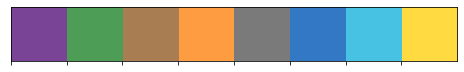

In [25]:
fuel_colour_dict_plt = convert_fuel_colour_dict_to_plt_tuple(fuel_colour_dict_rgb)

sns.palplot(fuel_colour_dict_plt.values())

<br>

Finally we can plot the stacked fuel plot itself

In [28]:
#exports
def stacked_fuel_plot(df, fuel_colour_dict, ax=None, save_path=None, dpi=150):
    df = df[fuel_colour_dict.keys()]
    
    if ax == None:
        fig = plt.figure(figsize=(10, 5), dpi=dpi)
        ax = plt.subplot()
    
    ax.stackplot(df.index.values, df.values.T, labels=df.columns.str.capitalize(), linewidth=0.25, edgecolor='white', colors=list(fuel_colour_dict.values()))

    plt.rcParams['axes.ymargin'] = 0
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlim(df.index.min(), df.index.max())
    ax.legend(ncol=4, bbox_to_anchor=(0.85, 1.15), frameon=False)
    ax.set_ylabel('Generation (GW)')

    if save_path:
        fig.savefig(save_path)
        
    return ax

<AxesSubplot:ylabel='Generation (GW)'>

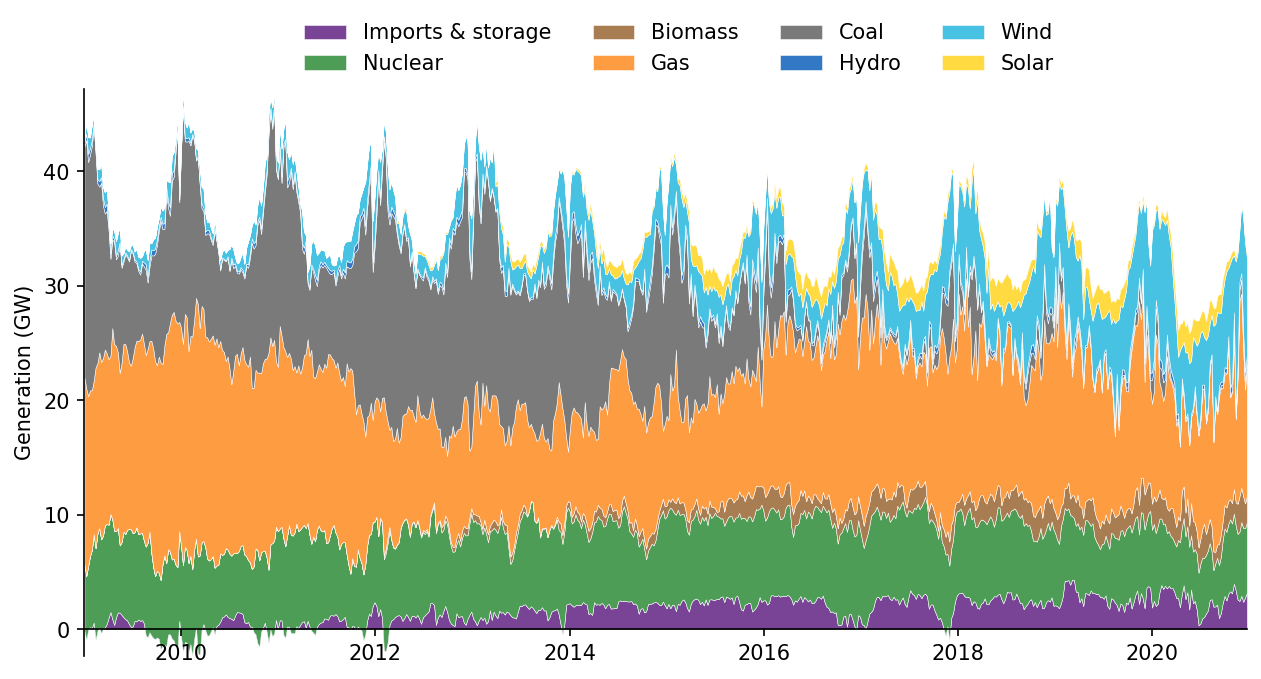

In [29]:
stacked_fuel_plot(df_plot, fuel_colour_dict_plt)

In [33]:
#hide
from nbdev.export import *
notebook2script()

Converted 01-retrieval.ipynb.
Converted 02-eda.ipynb.
Converted 03-lowess.ipynb.
